In [1]:
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
# from modelfunctions import *
%matplotlib inline

# Obtaining Data

In [2]:
control = 0 # 0: sinthetic; 1: real
mycmap = 'seismic'
np.random.seed(51)

In [3]:
def show_fft_image(img_fft, shift = True, save = False , name = 'my_name.png'):
    
    img_fftabs = img_fft
    if type(img_fft[0,0]) == np.complex128:
        img_fftabs = np.abs(img_fft)
    
    if shift:
        img_fftabs = np.fft.fftshift(img_fftabs)
    plt.imshow(img_fftabs, cmap=mycmap)
    plt.grid('off')
    
    if save:
        plt.savefig(name, format= 'png')

In [4]:
def phi(U,a,b,c,e,f):
    try:
        u = U[:,0]
        v = U[:,1]
    except IndexError:
        u = U[0]
        v = U[1]
    return np.exp(2*np.pi**2*(a*v**2 + b*u**2 - c*u*v)/(4.*a*b-c**2) -2*np.pi*1j*(f*v+e*u))

def psi(x,y, a, b, c, e, f):
    invSigma = np.array([[-2.0*a,-c],[-c, -2.0*b]]).reshape(2,2)
#     print(invSigma)
    
    if not isinstance(x,np.ndarray):
        xx = np.array([x-e,y-f])
    else:
        xx = np.stack([x-e,y-f], axis = 1).T
    
    return np.exp(-xx.T.dot(invSigma).dot(xx))

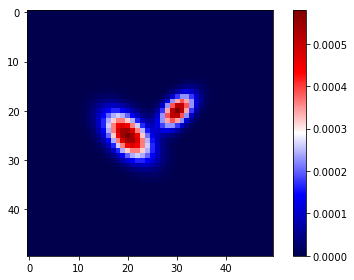

In [5]:
if control:
    path = '/home/lerko/Dataset_ALMA'
    fileName = 'Dataset_ALMA_11_07_17.mat'
    fullPath = path +'/' + fileName
    data = sio.loadmat(fullPath)
    imageName = 'name_HLTau'
    img = data['Dataset'][imageName][0,0]['size_128x128'][0,0]
    IMAGE_SIZE_X, IMAGE_SIZE_Y = img.shape
    x = np.arange(IMAGE_SIZE_X)
    y = np.arange(IMAGE_SIZE_Y)
    
    print(data['Dataset'].dtype)
elif not control:
    x = np.arange(50)
    y = np.arange(50)
    
    s1 = np.array([20,10])
    s2 = np.array([20,10])
    s12 = np.array([10,-5])

    a = -0.5*s2/(s1*s2-s12**2)
    b = -0.5*s1/(s1*s2-s12**2)
    c = s12/(s1*s2-s12**2)
#     invSigma = np.array([[-2.*a,-c],[-c, -2.*b]])
#     print(np.linalg.inv(invSigma))

    e = np.array([50,40])/2
    f = np.array([40,60])/2
    numberOfBasis = e.shape[0]
    img = np.zeros((x.shape[0],y.shape[0]))

    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            for k in range(numberOfBasis):
                img[i,j] = img[i,j] + psi(x[i],y[j],a[k],b[k],c[k],e[k],f[k])
    IMAGE_SIZE_X, IMAGE_SIZE_Y = img.shape

plt.imshow(0.00058*img/np.max(img), cmap=mycmap)
plt.colorbar()
plt.tight_layout()
# plt.savefig('{}.png'.format(imageName), format='png')

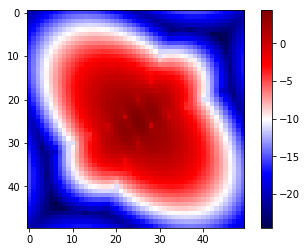

In [6]:
# Calculate the spectrum
img_fft= np.fft.fft2(img)
FTgshift = np.fft.fftshift(img_fft)

plt.imshow(np.log(np.abs(FTgshift)), cmap=mycmap)
plt.colorbar()

## Creating sampling mask

For creating the sampling mask, we have made a u,v representations based on the antennas disposition. This is because, if the antennas disposition is random, the measures are not completely random. The Measurements positions are defined by the interferometry physics.

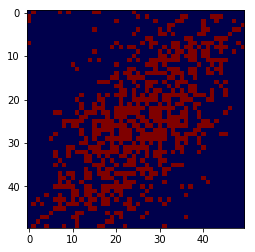

In [7]:
from masking import *

## Parameters
B_max = 1
antennas = 30
typeArray = 'URA'
sigma = B_max/6.0

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat, N1 = IMAGE_SIZE_X, N2 = IMAGE_SIZE_Y)
show_fft_image(mask)

## Sampling

Variable measurements are the 2D representation for the measurements. U are the positions in the u,v spaces, i.e., U[0] = u, U[1] = v. Finally, V is the visibility function.

Percentage of measurements: 26.36


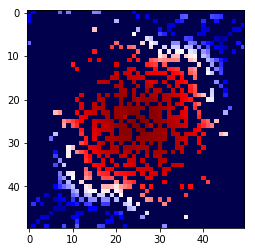

In [8]:
measurements,Uobs,Vobs = UVCreator(img_fft,mask)

measurements_abs = np.log(np.abs(measurements)+1e-12)
show_fft_image(measurements_abs)

percent = 100*Uobs.shape[0]/(measurements.shape[0]*measurements.shape[1]) 
print('Percentage of measurements: %s' % percent)

In [9]:
print('Getting indexes (u,v)->i..', end='')
mask_vect = mask.reshape(-1)
mask_vect_index = np.where(mask_vect == 1)[0]
mask_vect_index2 = np.concatenate([mask_vect_index, mask_vect_index])
print('done.')

Getting indexes (u,v)->i..done.


In [10]:
# Sampling Matrix

H = np.zeros((mask_vect_index.shape[0], IMAGE_SIZE_X*IMAGE_SIZE_Y))
# print(mask_vect)

p = 0
for q in range(H.shape[1]):
    if mask_vect[q] == 1:
        H[p,q] = 1
        p += 1
#         print(p,q)
# print(H)
H = H.T
print('H shape: {}'.format(H.shape))
print('Check sanity: {}'.format((np.matmul(H.T,np.arange(2500)) - mask_vect_index).sum() == 0))

H shape: (2500, 659)
Check sanity: True


# Model

### Fourier Matrix

In [11]:
import numpy as np
def DFT_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( -2 * np.pi * 1J / N )
    W = np.power( omega, i * j ) / np.sqrt(N)
    return W

Wizq = DFT_matrix(IMAGE_SIZE_X)
Wder = DFT_matrix(IMAGE_SIZE_Y)
W = np.kron(Wder.T,Wizq).T
print('Krockener product shape: {}'.format(W.shape))

Krockener product shape: (2500, 2500)


In [12]:
# plt.imshow(Kron.real)
# plt.colorbar()

In [13]:
# plt.imshow(W.real*W.real.T)
# plt.colorbar()

In [14]:
# plt.imshow(Kron.imag)
# plt.colorbar()

In [15]:
# plt.imshow(np.abs(Kron))
# plt.colorbar()

In [16]:
print('Separanting real and imaginary part...', end='')
Vrobs = Vobs[:,0]
Viobs = Vobs[:,1]
Vobs_concat = Vobs.reshape(-1, order='F')
print('done.')

Separanting real and imaginary part...done.


In [17]:
C = np.concatenate([np.eye(W.shape[0]), 1j*np.eye(W.shape[0])], axis=1)
print('C shape: {}'.format(C.shape))
V_concat = np.concatenate([img_fft.real.reshape(-1), img_fft.imag.reshape(-1)])[:,np.newaxis]
print('V concat shape: {}'.format(V_concat.shape))
W_new = np.matmul(W,C).real
I_concat = np.matmul(W_new,V_concat)

C shape: (2500, 5000)
V concat shape: (5000, 1)


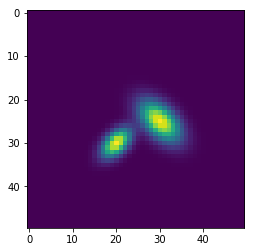

In [18]:
plt.imshow(I_concat.reshape(IMAGE_SIZE_Y, IMAGE_SIZE_X))

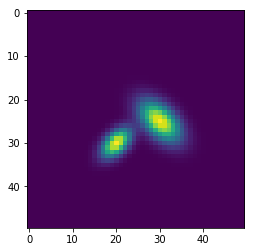

In [19]:
I = np.matmul(W,img_fft.reshape(-1))
plt.imshow(I.real.reshape(IMAGE_SIZE_Y, IMAGE_SIZE_X))

## Kernels

In [20]:
import scipy as sp

In [21]:
sigma = 1
gamma = 1./2

In [22]:
def kernel(i,j, sigma=sigma, gamma=gamma):
    return sigma**2*np.exp(-gamma*(i-j)**2)

def kernel_handler(x):
    return kernel()

def covImagReal(i,j, W=W):
    out = 0
    for k in range(W.shape[0]):
        for l in range(W.shape[1]):
            out += W[k,i] * kernel(k,l) * W[l,j]

In [23]:
# "suma" externa
def outersum(a,b):
    return np.outer(a,np.ones_like(b))+np.outer(np.ones_like(a),b)

In [24]:
def SE(a,b,gamma=1./2,sigma=1): 
    #Square Exponential kernel

    #returns the evaluation of the kernel
    #k(a,b)=sigma**2*exp(-gamma*(a-b)**2), 
    #notice that in this definition gamma = 1 /(2*lengthscale**2), in order to simplify the derivatives
    #for consistency with the generation of Gram matrices, this function returns
    #a matrix of dimensions dim(a) x dim(b);  

    #INPUTS
    #a,b are column vectors of (possibly) different lenghts
    u1 = a % IMAGE_SIZE_X
    u2 = b % IMAGE_SIZE_X
    
    v1 = np.floor(a/IMAGE_SIZE_X)
    v2 = np.floor(b/IMAGE_SIZE_X)
    
    sa=np.size(a); sb=np.size(b)

    if sa==1: a=np.array([a])
    if sb==1: b=np.array([b])
    K=np.zeros([sa,sb])
    #accelerate computation if a==b
    if np.array_equal(a,b):
        for va in range(sa):
            K[va,va]=1;
            for vb in range(va+1,sb):
                K[va,vb]=np.exp(-((u1[va] - u2[vb])**2 + (v1[va] - v2[vb])**2)*gamma)
                K[vb,va]=K[va,vb]
    #a!=b
    else:
        for va in range(sa):
            for vb in range(sb):
                K[va,vb]=np.exp(-((u1[va] - u2[vb])**2 + (v1[va] - v2[vb])**2)*gamma)
    if sa==1:
        return sigma**2*np.reshape(K,b.shape)
    elif sb==1:
        return sigma**2*np.reshape(K,a.shape)
    else:
        return sigma**2*K


In [25]:
samplingW = np.matmul(W.real,H)

#negative log-likelihood when using SE kernel
def like_covImagenReal(X, y, t): 
    #entrenamiento con respecto al logaritmo de los hyperparámetros, para no imponer restricciones de positividad
    sigma_noise, gamma_1, sig_1 = np.exp(X)
#     print('sigma noise: {}\ngamma: {}\nsigma: {}'.format(sigma_noise, gamma_1, sig_1))
#     print('------------')
    
    K = SE(t,t,gamma=gamma_1,sigma=sig_1)
    
#     Gram= np.matmul(np.matmul(samplingW.T,K),samplingW)+sigma_noise**2*np.identity(len(t))
    Gram = K+sigma_noise**2*np.identity(len(t))
    cGg=np.linalg.cholesky(Gram)
    invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
    
    nll=np.dot(y,np.dot(invGram,y)) + 2*np.sum(np.log(np.diag(cGg)))
    return 0.5*nll+0.5*len(y)*np.log(2*np.pi)

#derivative of negative log-likelihood when using SE kernel
def like_covImagenReal_Df(X, y, t, samplingW=samplingW, H=H):
    sigma_noise, gamma_1, sig_1 = np.exp(X)
    
#     W = np.identity(IMAGE_SIZE_X*IMAGE_SIZE_Y)
#     samplingW = np.matmul(W.real,H)
    
    Gram0 = SE(t,t,gamma=gamma_1,sigma=sig_1)
#     Gram = np.matmul(samplingW.T,np.matmul(Gram0, samplingW))+sigma_noise**2*np.identity(len(t))
    Gram = Gram0+sigma_noise**2*np.identity(len(t))
    cGg=np.linalg.cholesky(Gram)
    invGram=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
    
    A=np.dot(invGram,y)
    
    
    u_tmp = t % IMAGE_SIZE_X
    v_tmp = np.floor(t/IMAGE_SIZE_X)
    
    outer_u=outersum(u_tmp,-u_tmp)
    outer_v=outersum(v_tmp,-v_tmp)
    outer_dist = outer_u**2 + outer_v**2
#     print(outer_sub)

    
#     D1 = 2*sigma_noise**2*np.identity(len(t)) #sigma_noise
#     D2 = -Gram0*outer_dist*gamma_1 #gamma_1
#     D2 = np.matmul(samplingW.T, np.matmul(D2,samplingW))
#     D3 = np.matmul(samplingW.T, np.matmul(2*Gram0,samplingW)) #sig_1 

    D1 = 2*sigma_noise**2*np.identity(len(t)) #sigma_noise
    D2 = -Gram0*outer_dist*gamma_1 #gamma_1
    D3 = 2*Gram0 #sig_1 

    B=np.outer(A,A)-invGram
    d1=  -np.trace(np.dot(B,D1))
    d2=  -np.trace(np.dot(B,D2))
    d3=  -np.trace(np.dot(B,D3))

    print('- Paremeters:\n  - sigma noise: {},\n  - gamma: {},\n  - sigma: {}'.format(sigma_noise, gamma_1, sig_1))
    print('  - Derivatives: {}, {}, {}'.format(d1, d2, d3))
    return np.asarray([0.5*d1, 0.5*d2, 0.5*d3])

In [26]:
import time
from scipy.optimize import fmin_l_bfgs_b as fmin

#entrenamiento del GP, es decir, encontrar los parámetros del kernel y del ruido
args=(Vrobs, mask_vect_index)
time_SE=0
params0=np.asarray([0.000001, 0.1,  1])
X0=np.log(params0)
print('Condicion inicial optimizador: ',params0)
time_GP=time.time()
X_opt, f_GP, data=fmin(like_covImagenReal,X0,like_covImagenReal_Df, args,disp=1,factr=0.000001/(2.22E-12),maxiter=50)
# X_opt, f_GP, data = fmin(like_covImagenReal, X0, args=args, approx_grad=True)
time_GP=time.time()-time_GP
sigma_y_GP, gamma_1, sig_1 = np.exp(X_opt)
print('Hiperparametros encontrados: ', np.exp(X_opt))

print('Negative log-likelihood para hiperámetros optimizados: ', f_GP)

Condicion inicial optimizador:  [1.e-06 1.e-01 1.e+00]
- Paremeters:
  - sigma noise: 1.0000000000000004e-06,
  - gamma: 0.10000000000000002,
  - sigma: 1.0
  - Derivatives: -25030.745906663447, -71266062968.9367, -14745402922.051876
- Paremeters:
  - sigma noise: 1.000000343944568e-06,
  - gamma: 0.26624813077400894,
  - sigma: 1.22460069911719
  - Derivatives: -0.0028636447335595736, -19896398.001406714, -7771885.287179302
- Paremeters:
  - sigma noise: 1.0000003439445788e-06,
  - gamma: 0.2663209523157218,
  - sigma: 1.2247315398720298
  - Derivatives: -0.0028536386090168868, -19860060.15596518, -7759352.733868281
- Paremeters:
  - sigma noise: 1.0000003439446213e-06,
  - gamma: 0.266612437711298,
  - sigma: 1.2252550427013063
  - Derivatives: -0.002813979307359765, -19715426.089167114, -7709447.388529621
- Paremeters:
  - sigma noise: 1.0000003439447918e-06,
  - gamma: 0.26778157306329625,
  - sigma: 1.2273512926508914
  - Derivatives: -0.002661031532320191, -19148198.531417187, -7

- Paremeters:
  - sigma noise: 1.0000004947258978e-06,
  - gamma: 18.060526339123314,
  - sigma: 8.551248892906889
  - Derivatives: -8.367149504736376e-17, -0.0002828195826583388, -0.006087057352260672
- Paremeters:
  - sigma noise: 1.0000004959789814e-06,
  - gamma: 18.816477122416135,
  - sigma: 8.55126663305162
  - Derivatives: -8.431998574846705e-18, -0.0001383599284603724, -0.000601875957613629
- Paremeters:
  - sigma noise: 1.0000004971787637e-06,
  - gamma: 19.569911383840612,
  - sigma: 8.551271402029235
  - Derivatives: 1.1884735545425178e-17, -6.774044440056738e-05, 0.0008759843387338151
- Paremeters:
  - sigma noise: 1.0000004983295325e-06,
  - gamma: 20.32089444647662,
  - sigma: 8.551269948028702
  - Derivatives: 5.855328509435993e-18, -3.3193599408325884e-05, 0.0004314328327836847
- Paremeters:
  - sigma noise: 1.0000004994352248e-06,
  - gamma: 21.069594450236696,
  - sigma: 8.551268539603223
  - Derivatives: -3.4864663578467804e-20, -1.6278394416483474e-05, -1.004245433

In [27]:
t = np.arange(IMAGE_SIZE_X*IMAGE_SIZE_Y)
t_obs = mask_vect_index
N_obs = t_obs.shape[0]
# gamma_1 = 10
# sig_1 = 100
K = SE(t,t,gamma=gamma_1,sigma=sig_1)

# II = np.identity(IMAGE_SIZE_X*IMAGE_SIZE_Y)
# II = W.real

# samplingW = np.matmul(II, H)
print('W H shape: {}'.format(samplingW.shape))

# cov = np.matmul(np.matmul(II,K),II)
# cov_obs = np.matmul(np.matmul(samplingW.T,K),samplingW)
# K_star = np.matmul(np.matmul(II,K),samplingW)

cov = K
cov_obs = SE(t_obs,t_obs, gamma=gamma_1, sigma=sig_1)
K_star = SE(t,t_obs, gamma=gamma_1, sigma=sig_1)

# cGg=np.linalg.cholesky(cov_obs+sigma_y_GP**2*np.identity(N_obs))
cGg=np.linalg.cholesky(cov_obs+0.01**2*np.identity(N_obs))
invGramg=np.dot(np.linalg.inv(cGg.T),np.linalg.inv(cGg))
temp=np.matmul(K_star,invGramg) 
y_model=np.matmul(temp,Vrobs)
v_model=np.diag(cov-np.matmul(temp,K_star.T))

print('Variance: {}'.format(v_model))
std_dev= np.sqrt(v_model)
std_dev

W H shape: (2500, 659)
Variance: [7.31241936e+01 9.99998633e-05 9.99998633e-05 ... 9.99998633e-05
 7.31241936e+01 7.31241936e+01]


array([8.55126854, 0.00999999, 0.00999999, ..., 0.00999999, 8.55126854,
       8.55126854])

In [28]:
# (K_star == SE(t,t_obs,gamma=0.0005,sigma=1)).all()

In [29]:
print('Variance sanity check: {}'.format( (v_model>0).all() ))
print(np.where(v_model<0))
print(v_model[2400])

Variance sanity check: True
(array([], dtype=int64),)
9.999986326647559e-05


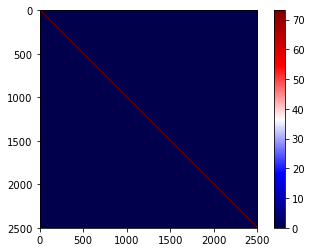

In [30]:
plt.imshow(K, cmap='seismic')
plt.colorbar()

(100, 200)

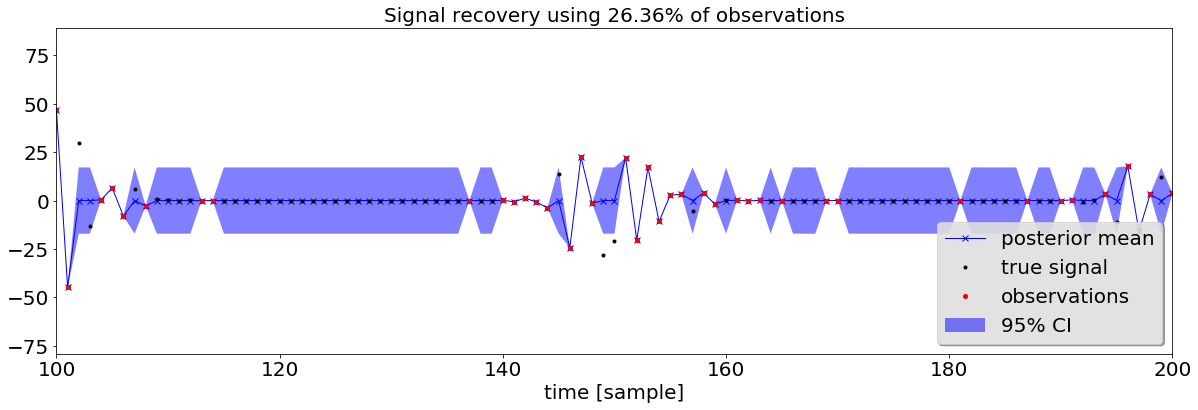

In [31]:
my_label_size = 20
label_size = 20
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 

#plotear estimacion, observaciones y datos totales
fig=plt.figure(3, figsize=(20,6))
ax = plt.gca()
plt.fill_between(t, y_model-2*std_dev, y_model+2*std_dev, facecolor='blue', alpha=0.5, label='95% CI')
plt.plot(t,y_model, c='b', linestyle='-', marker='x',lw=1,label='posterior mean')
plt.plot(t,img_fft.real.reshape(-1), c='black', marker='.', linestyle='none',label='true signal')
plt.plot(mask_vect_index,Vrobs,'red',ms=8, linestyle='none', marker='.', label='observations')

leg=plt.legend(ncol=1,frameon=True, shadow=True, loc=4, fontsize=my_label_size)
frame  = leg.get_frame()
frame.set_facecolor('0.95')
plt.xlabel('time [sample]', fontsize=my_label_size)
plt.title('Signal recovery using {}% of observations'.format(percent), fontsize=my_label_size)
# plt.xlim([2400,2500])
plt.xlim([100,200])

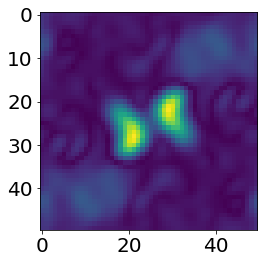

In [32]:
I_fft_mod_real = y_model.reshape((IMAGE_SIZE_Y,IMAGE_SIZE_X))
# I_fft_mod_real = img_fft.real
# I_fft_mod_real = measurements.real

I_fft_mod_imag = np.zeros_like(I_fft_mod_real)
I_fft_mod = I_fft_mod_real + 1j*I_fft_mod_imag
I_mod = np.fft.ifft2(I_fft_mod)
plt.imshow(np.abs(I_mod))